In [199]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import fsolve

# Making fonts look good!
import matplotlib
matplotlib.rcParams.update({
    'font.family': 'serif',
    'text.usetex': False,
})
pathstring = "/Users/lukevaneyk/OneDrive - University of Pretoria/Postgrad/Masters/Articles/PreFigs/"

In [192]:
############### DEPENDENT LIBRARIES ##########################
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import fsolve
##############################################################

####################### USER AID #######################################
def RadiusFinder(Z1,Z2,m1,m2,a0,ha = 1, c = 0.25):
    '''
    Z1 - Driving gear number of teeth
    Z2 - Driven gear number of teeth
    m1 - Driving gear module (in metres)
    m2 - Driven gear module (in metres)
    a0 - Pressure angle (radians)
    ha - Addendum coefficient (The default of 1 is a commonly accepted value)
    c  - Tip clearance coefficient (The default of 0.25 is a commonly accepted value)
    '''
    Rb1 = 0.5*m1*Z1*np.cos(a0)  # Base circle radius for pinion
    Rr1 = 0.5*m1*Z1 - (ha+c)*m1 # Root circle radius for pinion

    Rb2 = 0.5*m2*Z2*np.cos(a0)  # Base circle radius for gear
    Rr2 = 0.5*m2*Z2 - (ha+c)*m2 # Root circle radius for gear
    
    return Rb1,Rr1,Rb2,Rr2
########################################################################

###################### ANGULAR FUNCTIONS #################################
def A1(T,Z1,Z2,a0,GP=1,GT=0):
    '''
    T - Theta
    GT - Gear Type: 0 = Pinion, 1 = Gear
    GP - Gear Pairs Engaged: 1 = 1 Pair, 2 = 2 Pairs
    '''
    if GT == 0 and GP == 1: # Pinion - 1st Gear Pair
        botterm = np.sqrt((Z2+2)**2 +(Z1+Z2)**2-2*(Z2+2)*(Z1+Z2)*np.cos(np.arccos(Z2*np.cos(a0)/(Z2+2))-a0))
        result = T - np.pi/(2*Z1) - np.tan(a0) + a0 + np.tan(np.arccos(Z1*np.cos(a0)/botterm))

    elif GT == 0 and GP == 2: # Pinion - 2nd Gear Pair
        botterm = np.sqrt((Z2+2)**2 +(Z1+Z2)**2-2*(Z2+2)*(Z1+Z2)*np.cos(np.arccos(Z2*np.cos(a0)/(Z2+2))-a0))
        result = T + 3*np.pi/(2*Z1) - np.tan(a0) + a0 + np.tan(np.arccos(Z1*np.cos(a0)/botterm))
        

    
    
    elif GT == 1 and GP == 1: # Driven Gear - 1st Gear Pair
        result = np.tan(np.arccos(Z2*np.cos(a0)/(Z2+2))) - np.pi/(2*Z2) - np.tan(a0) + a0 - Z1/Z2 * T
        
    elif GT == 1 and GP == 2: # Driven Gear - 2nd Gear Pair
        result = np.tan(np.arccos(Z2*np.cos(a0)/(Z2+2))) - 5*np.pi/(2*Z2) - np.tan(a0) + a0 - Z1/Z2 * T
    else:
        print('Invalid value for GT or GP entered')
    return result

def A2(Z,a0):
    return np.pi/(2*Z) + np.tan(a0) - a0

def A3(a2,Rb,Rr):
    return np.arcsin(Rb*np.sin(a2)/Rr)



def A5(Rb,Rr,a2):
    
    def func(a5,Rb,Rr,a2):
        return (Rb/Rr)**2 * (((a2-a5)*np.cos(a5) - np.sin(a5))**2 + ((a5-a2)*np.sin(a5) + np.cos(a5))**2) - 1
    a5 = fsolve(func,1, args = (Rb,Rr,a2))
    return a5[0]


def DoubleMeshPeriod(Z1,Z2,a0):
    term1 = np.tan(np.arccos((Z1*np.cos(a0))/(Z1+2)))
    term2 = -2*np.pi/Z1
    term3 = -np.tan(np.arccos(Z1*np.cos(a0)/np.sqrt((Z2+2)**2 +(Z1+Z2)**2-2*(Z2+2)*(Z1+Z2)*np.cos(np.arccos(Z2*np.cos(a0)/(Z2+2))-a0))))
    return (term1 + term2 + term3)
#####################################################################

########################### STIFFNESSES ############################
def invkb(Z1,Z2,L,T,Rb,Rr,GP,GT,alpha_mem,dIx_mem,damage,a0,granularity = 100,E = 2.068*10**11):
    
    if GT == 0:
        Z = Z1
    else:
        Z = Z2
        
    
    a1 = A1(T,Z1,Z2,a0,GP,GT)
    a2 = A2(Z,a0)
    intStop = a2
    a3 = A3(a2,Rb,Rr)
    constTerm = 0
    
    if Rb>=Rr: # We have to add some are that we are neglecting since the tooth actually starts at Rr
        # Constant Term
        if damage == 1 and GP == 1 and GT == 0: # Ensure only pinion gets damaged.
            #################################################
            Ix1 = getdIxVal(a2,alpha_mem,dIx_mem) 
            #################################################
            constTop = Rb**3 * ((1-Rr/Rb * np.cos(a1)*np.cos(a3))**3 - (1-np.cos(a1)*np.cos(a2))**3)
            constBot = E*np.cos(a1) *3  * Ix1
            constTerm = constTop/constBot
        else:
            constTop = (1-Rr/Rb * np.cos(a1)*np.cos(a3))**3 - (1-np.cos(a1)*np.cos(a2))**3
            constBot = 2*E*L*np.cos(a1) * np.sin(a2)**3
            constTerm = constTop/constBot
            
    else: # Otherwise, now we just have to integrate up to a5, and not a2
        a5 = A5(Rb,Rr,a2)
        a4 = np.arccos(Rb/Rr*((a5-a2)*np.sin(a5) + np.cos(a5)))
        intStop = a5
        
    # Integration Term
    IntTerm = np.zeros(len(T))
    irange = np.arange(len(T))

    for i in irange:
        a1i = a1[i]
        a2i = intStop
        
        a = np.linspace(-a1i,a2i,granularity)
        if damage == 1 and GP == 1 and GT == 0: # Ensure only pinion gets damaged.
            #################################################
            Ixmod = getdIxVal(a,alpha_mem,dIx_mem) 
            #################################################
            IntTop = (1+np.cos(a1i)*((a2-a)*np.sin(a) - np.cos(a)))**2*(a2-a)*np.cos(a) * Rb**3
            IntBot = E*Ixmod
        else:
            IntTop = 3*(1+np.cos(a1i)*((a2-a)*np.sin(a) - np.cos(a)))**2*(a2-a)*np.cos(a) 
            IntBot = 2*E*L*(np.sin(a) + (a2-a)*np.cos(a))**3 

    
        dInt = np.diff(a)[0]
        IntTerm[i] = np.sum(IntTop/IntBot * dInt)
    return constTerm + IntTerm


def invks(Z1,Z2,L,T,Rb,Rr,GP,GT,alpha_mem,dAx_mem,damage,a0,granularity = 100,E = 2.068*10**11,nu = 0.3):
    
    if GT == 0:
        Z = Z1
    else:
        Z = Z2
        
    a1 = A1(T,Z1,Z2,a0,GP,GT)
    a2 = A2(Z,a0)
    intStop = a2
    a3 = A3(a2,Rb,Rr)
    constTerm = 0
    d1 = Rb*np.cos(a2) - Rr*np.cos(a3)
    
    if Rb>=Rr: # We have to add some are that we are neglecting since the tooth actually starts at Rr
        # Constant Term
        if damage == 1 and GP == 1 and GT == 0:
            #################################################
            Ax1 = getdAxVal(a2,alpha_mem,dAx_mem)
            #################################################
            constTop = Rb* 2.4*(1+nu)*np.cos(a1)**2 *d1
            constBot = E*Ax1 
            constTerm = constTop/constBot
        else:
            constTop = 1.2*(1+nu)*np.cos(a1)**2 *d1
            constBot = E*L*np.sin(a2) 
            constTerm = constTop/constBot
            
    else: # Otherwise, now we just have to integrate up to a5, and not a2
        a5 = A5(Rb,Rr,a2)
        a4 = np.arccos(Rb/Rr*((a5-a2)*np.sin(a5) + np.cos(a5)))
        intStop = a5
        
        
    # Integration Term
    IntTerm = np.zeros(len(T))
    irange = np.arange(len(T))
    for i in irange:
        a1i = a1[i]
        a2i = intStop
        a3i = a3
        
        a = np.linspace(-a1i,a2i,granularity)
        if damage == 1 and GP == 1 and GT == 0:
            #################################################
            Ax = getdAxVal(a,alpha_mem,dAx_mem) # Term used to switch damage on or off
            #################################################
            IntTop = 2.4*(1+nu)*(a2-a)*np.cos(a)*np.cos(a1i)**2  * Rb
            IntBot = E*Ax
        else:
            IntTop = 1.2*(1+nu)*(a2-a)*np.cos(a)*np.cos(a1i)**2
            IntBot = E*L*(np.sin(a)+(a2-a)*np.cos(a))
            
        dInt = np.diff(a)[0]
        IntTerm[i] = np.sum(IntTop/IntBot * dInt)
    return constTerm + IntTerm


def invka(Z1,Z2,L,T,Rb,Rr,GP,GT,alpha_mem,dAx_mem,damage,a0,granularity = 100,E = 2.068*10**11):
      
    if GT == 0:
        Z = Z1
    else:
        Z = Z2
        
    a1 = A1(T,Z1,Z2,a0,GP,GT)
    a2 = A2(Z,a0)
    intStop = a2
    a3 = A3(a2,Rb,Rr)
    constTerm = 0
    d1 = Rb*np.cos(a2) - Rr*np.cos(a3)
    
    if Rb>Rr: # We have to add some are that we are neglecting since the tooth actually starts at Rr
        # Constant Term
        if damage == 1 and GP == 1 and GT == 0:
            #################################################
            Ax1 = getdAxVal(a2,alpha_mem,dAx_mem)
            #################################################
            constTop = Rb*np.sin(a1)**2*d1
            constBot = E*Ax1 
            constTerm = constTop/constBot
        else:
            constTop = np.sin(a1)**2*d1
            constBot = 2*E*L*np.sin(a2) 
            constTerm = constTop/constBot
        
    else: # Otherwise, now we just have to integrate up to a5, and not a2
        a5 = A5(Rb,Rr,a2)
        a4 = np.arccos(Rb/Rr*((a5-a2)*np.sin(a5) + np.cos(a5)))
        intStop = a5
        
    # Integration Term
    IntTerm = np.zeros(len(T))
    irange = np.arange(len(T))
    for i in irange:
        a1i = a1[i]
        a2i = intStop
        a3i = a3
        
        a = np.linspace(-a1i,a2i,granularity)
        
        if damage == 1 and GP == 1 and GT == 0:
            #################################################
            Ax = getdAxVal(a,alpha_mem,dAx_mem) # Term used to switch damage on or off
            #################################################
            IntTop = (a2-a)*np.cos(a)*np.sin(a1i)**2  * Rb
            IntBot = E*Ax
        else:
            IntTop = (a2-a)*np.cos(a)*np.sin(a1i)**2
            IntBot = E*(2*L*(np.sin(a)+(a2-a)*np.cos(a)))

            
        dInt = np.diff(a)[0]
        IntTerm[i] = np.sum(IntTop/IntBot * dInt)
    return constTerm + IntTerm


def invkh(Z1,Z2,L,T,GP,GT,damage,alpha_mem,dL_mem,a0,granularity = 100,E = 2.068*10**11,nu = 0.3):
    a1 = A1(T,Z1,Z2,a0,GP,GT)
    cterm = 4*(1-nu**2)/(np.pi*E)
    Lnew = L
    if damage == 1 and GP == 1 and GT == 0:
        Lnew = getdLVal(-a1,alpha_mem,dL_mem)
    result = cterm * 1/Lnew
    return result



def Xi(h,Tf,Ai,Bi,Ci,Di,Ei,Fi):
    
    return Ai/Tf**2 + Bi*h**2 + Ci*h/Tf + Di/Tf + Ei*h + Fi



def invkf(Z1,Z2,L,T,Rb,Rr,GP,GT,hi,damage,alpha_mem,dL_mem,a0,E = 2.068*10**11,hat = 1, rcbar = 0.2):
    '''
    hat - Tool tip addendum coefficient - From original article
    rcbar - Tool tip radius - From original article
    '''
    
    if GT == 0:
        Z = Z1
    else:
        Z = Z2
    
    a1 = A1(T,Z1,Z2,a0,GP,GT)
    a2 = A2(Z,a0)
    a3 = A3(a2,Rb,Rr)
    Lnew = L
    Tf = 1/Z * (np.pi/2 + 2*np.tan(a0)*(hat - rcbar) + 2*rcbar/np.cos(a0))
    ###########################################
    Sf = 2*Tf*Rr # I'm Guessing this is correct

    h = Rb*((a1+a2)*np.cos(a1) - np.sin(a1))
    if Rb>=Rr: # We have to add some are that we are neglecting since the tooth actually starts at Rr
        d  = Rb*((a1+a2)*np.sin(a1)+np.cos(a1)) - Rr*np.cos(a3)
    else: # Otherwise, now we just have to integrate up to a5, and not a2
        a5 = A5(Rb,Rr,a2)
        a4 = np.arcsin(Rb/Rr*((a2-a5)*np.cos(a5)-np.sin(a5)))
        d  = Rb*((a1+a2)*np.sin(a1)+np.cos(a1)) - Rr*np.cos(a4) 
        
    uf = d-h*np.tan(a1) # This is my own derivation.

    
    # CONSTANT VALUES
    ###########################################################################################################
    AL,BL,CL,DL,EL,FL =  -5.574*10**(-5), -1.9986*10**(-3), -2.3015*10**(-4),  4.7702*10**(-3),  0.0271, 6.8045
    AM,BM,CM,DM,EM,FM =  60.111*10**(-5),  28.100*10**(-3), -83.431*10**(-4), -9.9256*10**(-3),  0.1624, 0.9086
    AP,BP,CP,DP,EP,FP = -50.952*10**(-5),  185.50*10**(-3),  0.0538*10**(-4),  53.300*10**(-3),  0.2895, 0.9236
    AQ,BQ,CQ,DQ,EQ,FQ = -6.2042*10**(-5),  9.0889*10**(-3), -4.0964*10**(-4),  7.8297*10**(-3), -0.1472, 0.6904
    ###########################################################################################################

    Lstar = Xi(hi,Tf,AL,BL,CL,DL,EL,FL)
    Mstar = Xi(hi,Tf,AM,BM,CM,DM,EM,FM)
    Pstar = Xi(hi,Tf,AP,BP,CP,DP,EP,FP)
    Qstar = Xi(hi,Tf,AQ,BQ,CQ,DQ,EQ,FQ)
    
#     if damage == 1 and GP == 1 and GT == 0:
#         Lnew = getdLVal(-a1,alpha_mem,dL_mem)
    
    result = np.cos(a1)**2/(E*Lnew)*(Lstar*(uf/Sf)**2 + Mstar*(uf/Sf) + Pstar*(1+Qstar*np.tan(a1)**2))
    return result
####################################################################


######################## FAULT INTERPOLATORS ########################
def getdLVal(alpha_vals,alpha_mem,dL_mem):
    dL = np.interp(alpha_vals,alpha_mem,dL_mem)
    return dL

def getdAxVal(alpha_vals,alpha_mem,dAx_mem):
    dAx = np.interp(alpha_vals,alpha_mem,dAx_mem)
    return dAx

def getdIxVal(alpha_vals,alpha_mem,dIx_mem):
    dIx = np.interp(alpha_vals,alpha_mem,dIx_mem)
    return dIx
####################################################################


######################### FAULT GENERATION FUNCTIONS ###########################
# def generateCrackingFaults(q0,q2,v,Wc,Z1,Z2,L,Rb,Rr,no_points,a0):
#     term1 = np.tan(np.arccos((Z1*np.cos(a0))/(Z1+2)))
#     term2 = -2*np.pi/Z1
#     term3 = -np.tan(np.arccos(Z1*np.cos(a0)/np.sqrt((Z2+2)**2 +(Z1+Z2)**2-2*(Z2+2)*(Z1+Z2)*np.cos(np.arccos(Z2*np.cos(a0)/(Z2+2))-a0))))

#     Td = (term1 + term2 + term3) # Double Meshing Angle
#     Ts = 2*np.pi/Z1 - Td # Single Meshing Angle

#     Theta_mem = Td+Ts+Td
    
#     a1 = A1(Theta_mem,Z1,Z2,a0,1,0) # I fix the gear tooth to the driving gear from pair 1
#     a2 = A2(Z1,a0)
#     a3 = A3(a2,Rb,Rr)
    


    
#     # THE ASSUMPTION IS THAT WE START CRACK AT TOOTH ROOT, THUS AT HX = RBSINA2
    
    
#     if Rb>Rr:
#         d1 = np.sqrt(Rb**2 + Rr**2 - 2*Rb*Rr*np.cos(a3-a2)) # This is 0.48% different from just simply saying Rb-Rr    
#         alpha_mem = np.linspace(-a1,a2,no_points)
#         d  = Rb*((a1+a2)*np.sin(a1)+np.cos(a1)) - Rr*np.cos(a3)
#         xarr = Rb*(-(-alpha_mem+a2)*np.sin(alpha_mem)+np.cos(alpha_mem) ) - Rr*np.cos(a3)
#         hc = Rb*np.sin(a2) # a = a2 in equation for hx.

        
#     else:
#         d1 = -100
#         a5 = A5(Rb,Rr,a2)
# #         a4 = np.arcsin(Rb/Rr*((a2-a5)*np.cos(a5)-np.sin(a5))) - Delivers same result
#         a4 = np.arccos(Rb/Rr*((a5-a2)*np.sin(a5) + np.cos(a5))) # Comes from def of x=0
#         alpha_mem = np.linspace(-a1,a5,no_points)        
#         d  = Rb*((a1+a2)*np.sin(a1)+np.cos(a1)) - Rr*np.cos(a4) 
#         xarr = Rb*(-(-alpha_mem+a2)*np.sin(alpha_mem)+np.cos(alpha_mem) ) - Rr*np.cos(a4)
#         hc = Rb*((a2-a5)*np.cos(a5) + np.sin(a5)) # a = a5 in equation for hx.

#     L_mem = np.ones(len(alpha_mem))*L
#     Ax_mem = np.zeros(len(alpha_mem))
#     Ix_mem = np.zeros(len(alpha_mem))


#     hmax = Rb*np.sin(a2)
#     for i in range(len(alpha_mem)):
#         x = xarr[i]
#         if 0<=x and x<= d1:
#             hx = Rb*np.sin(a2) # This corresponds to a straight line to the root circle. Cool.

#         elif d1 < x and x<=d:
#             hx = Rb*((a2-alpha_mem[i])*np.cos(alpha_mem[i]) + np.sin(alpha_mem[i]))
            
#         else:
#             print('Error in Code')
#             print(i,x,d)
        
#         q0n = q0*np.sin(v)
#         q2n = q2*np.sin(v)
        
#         if q2n == 0: # Not full width crack   
#             zi = 0
#             if hx >= (hmax-q0n): # In cracked region
#                 zi = Wc*(1-((hmax-hx)/q0n)**2)
#             hxbar = zi/L*(hmax-hx) + hx + 2*q0n/(3*(L*Wc**0.5)) * ((Wc-zi)**1.5 - (Wc)**1.5)
                
#         else: # Full width crack type. Formulation of qz changes (and zi in turn)
#             if q0n == q2n:
#                 hxbar = hmax - q0n
                
#             else:
#                 zi = 0
#                 if hx >= (hmax-q0n) and hx<=(hmax-q2n): #Region between q0 and q2 (A cracked region)
#                     zi = (L*((hmax-hx)**2 - q0n**2))/(q2n**2 - q0n**2)
#                 elif hx >= (hmax-q0n) and hx>(hmax-q2n): # Region above q2
#                     zi = L

#                 hxbar = zi/L*(hmax-hx) + hx -  (2)/(3*(q2n**2 - q0n**2)) * (((q2n**2 - q0n**2)/(L) * zi + q0n**2)**1.5 - q0n**3)


        
#         Ax_mem[i] = (hxbar+hx)*L
#         Ix_mem[i] = 1/12 * (hxbar+hx)**3 *L


#     return alpha_mem, L_mem, Ax_mem, Ix_mem

def generateCrackingFaults(q0,q2,v,Wc,Z1,Z2,L,Rb,Rr,no_points,a0):
    term1 = np.tan(np.arccos((Z1*np.cos(a0))/(Z1+2)))
    term2 = -2*np.pi/Z1
    term3 = -np.tan(np.arccos(Z1*np.cos(a0)/np.sqrt((Z2+2)**2 +(Z1+Z2)**2-2*(Z2+2)*(Z1+Z2)*np.cos(np.arccos(Z2*np.cos(a0)/(Z2+2))-a0))))

    Td = (term1 + term2 + term3) # Double Meshing Angle
    Ts = 2*np.pi/Z1 - Td # Single Meshing Angle

    Theta_mem = Td+Ts+Td
    
    a1 = A1(Theta_mem,Z1,Z2,a0,1,0) # I fix the gear tooth to the driving gear from pair 1
    a2 = A2(Z1,a0)
    a3 = A3(a2,Rb,Rr)
    


    
    # THE ASSUMPTION IS THAT WE START CRACK AT TOOTH ROOT, THUS AT HX = RBSINA2
    
    
    if Rb>Rr:
        d1 = np.sqrt(Rb**2 + Rr**2 - 2*Rb*Rr*np.cos(a3-a2)) # This is 0.48% different from just simply saying Rb-Rr    
        alpha_mem = np.linspace(-a1,a2,no_points)
        d  = Rb*((a1+a2)*np.sin(a1)+np.cos(a1)) - Rr*np.cos(a3)
        xarr = Rb*(-(-alpha_mem+a2)*np.sin(alpha_mem)+np.cos(alpha_mem) ) - Rr*np.cos(a3)
        hc = Rb*np.sin(a2) # a = a2 in equation for hx.

        
    else:
        d1 = -100
        a5 = A5(Rb,Rr,a2)
#         a4 = np.arcsin(Rb/Rr*((a2-a5)*np.cos(a5)-np.sin(a5))) - Delivers same result
        a4 = np.arccos(Rb/Rr*((a5-a2)*np.sin(a5) + np.cos(a5))) # Comes from def of x=0
        alpha_mem = np.linspace(-a1,a5,no_points)        
        d  = Rb*((a1+a2)*np.sin(a1)+np.cos(a1)) - Rr*np.cos(a4) 
        xarr = Rb*(-(-alpha_mem+a2)*np.sin(alpha_mem)+np.cos(alpha_mem) ) - Rr*np.cos(a4)
        hc = Rb*((a2-a5)*np.cos(a5) + np.sin(a5)) # a = a5 in equation for hx.

    L_mem = np.ones(len(alpha_mem))*L
    Ax_mem = np.zeros(len(alpha_mem))
    Ix_mem = np.zeros(len(alpha_mem))


    hmax = Rb*np.sin(a2)
    hb = hmax # Corresponds to my report
    hmin = np.min(Rb*((a2-alpha_mem)*np.cos(alpha_mem) + np.sin(alpha_mem)))
    for i in range(len(alpha_mem)):
        x = xarr[i]
        if 0<=x and x<= d1:
            hx = Rb*np.sin(a2) # This corresponds to a straight line to the root circle. Cool.

        elif d1 < x and x<=d:
            hx = Rb*((a2-alpha_mem[i])*np.cos(alpha_mem[i]) + np.sin(alpha_mem[i]))
            
        else:
            print('Error in Code')
            print(i,x,d)
        
        
        
        
        if q2 == 0: # Not full width crack   
            hq1 = hb - ((2*q0*Wc)/(3*L))*np.sin(v)

            if hx <= hq1:
                hxbar = hx
            else:
#                 print(hmax, hmax-hx)
                hxbar = (hx+(hb - q0))/2
                hxbar = np.max([0,hxbar])
                

        else:
            eta = 1e-9 # very small number to stop division by 0
            hq2 = hb - (2/3 * ((q2+eta)**3 -q0**3)/(((q2+eta)**2 -q0**2)))*np.sin(v)

            if hx <= hq2:
                hxbar = hx
            else:
                hxbar = (hx+(hb - q0))/2
                hxbar = np.max([0,hxbar])
        
        Ax_mem[i] = (hxbar*2)*L
        Ix_mem[i] = 1/12 * (hxbar*2)**3 *L


    return alpha_mem, L_mem, Ax_mem, Ix_mem


def generateChippingFaults(b,c,Z1,Z2,L,Rb,Rr,no_points,a0):
    term1 = np.tan(np.arccos((Z1*np.cos(a0))/(Z1+2)))
    term2 = -2*np.pi/Z1
    term3 = -np.tan(np.arccos(Z1*np.cos(a0)/np.sqrt((Z2+2)**2 +(Z1+Z2)**2-2*(Z2+2)*(Z1+Z2)*np.cos(np.arccos(Z2*np.cos(a0)/(Z2+2))-a0))))

    Td = (term1 + term2 + term3) # Double Meshing Angle
    Ts = 2*np.pi/Z1 - Td # Single Meshing Angle

    Theta_mem = Td+Ts+Td
    
    a1 = A1(Theta_mem,Z1,Z2,a0,1,0) # I fix the gear tooth to the driving gear from pair 1
    a2 = A2(Z1,a0)
    a3 = A3(a2,Rb,Rr)
    
    
    
    ########################################
    
    if Rb>Rr:
        d1 = np.sqrt(Rb**2 + Rr**2 - 2*Rb*Rr*np.cos(a3-a2)) # This is 0.48% different from just simply saying Rb-Rr    
        alpha_mem = np.linspace(-a1,a2,no_points)
        d  = Rb*((a1+a2)*np.sin(a1)+np.cos(a1)) - Rr*np.cos(a3)
        xarr = Rb*(-(-alpha_mem+a2)*np.sin(alpha_mem)+np.cos(alpha_mem) ) - Rr*np.cos(a3)

    else:
        d1 = -100 # just negative enough to keep any small negative x's out of the else statement below...
        a5 = A5(Rb,Rr,a2)
        a4 = np.arccos(Rb/Rr*((a5-a2)*np.sin(a5) + np.cos(a5)))
        alpha_mem = np.linspace(-a1,a5,no_points)        
        d  = Rb*((a1+a2)*np.sin(a1)+np.cos(a1)) - Rr*np.cos(a4) 
        xarr = Rb*(-(-alpha_mem+a2)*np.sin(alpha_mem)+np.cos(alpha_mem) ) - Rr*np.cos(a4)
    ######################################

    dmax  = np.max(xarr)    
    dL_mem = np.zeros(len(xarr))
    dAx_mem = np.zeros(len(xarr))
    dIx_mem = np.zeros(len(xarr))
    
    u = dmax - b
    
    for i in range(len(xarr)):
        x = xarr[i]
        if 0<=x and x<= d1:
            hx = Rb*np.sin(a2) # This corresponds to a straight line to the root circle. Cool.

        elif d1 < x and x<=d:
            hx = Rb*((a2-alpha_mem[i])*np.cos(alpha_mem[i]) + np.sin(alpha_mem[i]))

        else:
            print('Error in Code')
            print(i,x,d)
        dL = L
        dAx_mem[i] = 2*hx*L
        dIx_mem[i] = 2/3*hx**3 * L

        if u <= x:
            dh = u+b
            dL = L - (dh*c/b - (dh**2*c/b - dh*c)/x) 
        dL_mem[i] = dL
    return alpha_mem, dL_mem, dAx_mem, dIx_mem


def generatePittingFaults(u_range, pa_range, r_range,Z1,Z2,L,Rb,Rr,no_points,a0):
    term1 = np.tan(np.arccos((Z1*np.cos(a0))/(Z1+2)))
    term2 = -2*np.pi/Z1
    term3 = -np.tan(np.arccos(Z1*np.cos(a0)/np.sqrt((Z2+2)**2 +(Z1+Z2)**2-2*(Z2+2)*(Z1+Z2)*np.cos(np.arccos(Z2*np.cos(a0)/(Z2+2))-a0))))

    Td = (term1 + term2 + term3) # Double Meshing Angle
    Ts = 2*np.pi/Z1 - Td # Single Meshing Angle

    Theta_mem = Td+Ts+Td
    
    a1 = A1(Theta_mem,Z1,Z2,a0,1,0) # I fix the gear tooth to the driving gear from pair 1
    a2 = A2(Z1,a0)
    a3 = A3(a2,Rb,Rr)
    
    
    
    ########################################
    
    if Rb>Rr:
        d1 = np.sqrt(Rb**2 + Rr**2 - 2*Rb*Rr*np.cos(a3-a2)) # This is 0.48% different from just simply saying Rb-Rr    
        alpha_mem = np.linspace(-a1,a2,no_points)
        d  = Rb*((a1+a2)*np.sin(a1)+np.cos(a1)) - Rr*np.cos(a3)
        xarr = Rb*(-(-alpha_mem+a2)*np.sin(alpha_mem)+np.cos(alpha_mem) ) - Rr*np.cos(a3)

    else:
        d1 = -100 # just negative enough to keep any small negative x's out of the else statement below...
        a5 = A5(Rb,Rr,a2)
        a4 = np.arccos(Rb/Rr*((a5-a2)*np.sin(a5) + np.cos(a5)))
        alpha_mem = np.linspace(-a1,a5,no_points)        
        d  = Rb*((a1+a2)*np.sin(a1)+np.cos(a1)) - Rr*np.cos(a4) 
        xarr = Rb*(-(-alpha_mem+a2)*np.sin(alpha_mem)+np.cos(alpha_mem) ) - Rr*np.cos(a4)
    ######################################
    
    
    
    dL_mem = np.zeros((len(pa_range),len(xarr)))
    dAx_mem = np.zeros((len(pa_range),len(xarr)))
    dIx_mem = np.zeros((len(pa_range),len(xarr)))
    
    L_mem = np.zeros(len(xarr))
    Ax_mem = np.zeros(len(xarr))
    Ix_mem = np.zeros(len(xarr))
    
    for i in range(len(xarr)):
        x = xarr[i]
        if 0<=x and x<= d1:
            hx = Rb*np.sin(a2)
        elif d1 < x  and x<=d:
            
            hx = Rb*((a2-alpha_mem[i])*np.cos(alpha_mem[i]) + np.sin(alpha_mem[i]))
        else:
            print('Error in Code')
            print(i,x,d)
        
        Ax = 2*hx*L
        Ix = 2/3*hx**3*L
            
        for j in range(len(pa_range)):
            pa = pa_range[j]
            r = r_range[j]
            u = u_range[j]

            
            if u-(r*np.sin(pa)) <= x and x <= u+(r*np.sin(pa)):
                dL = 2*np.sqrt((r*np.sin(pa))**2 - (u-x)**2)
                dL_mem[j,i] = dL

            if u-r <= x and x <= u+r:
                dR = np.sqrt((r)**2 - (u-x)**2) 
                dAx = dR**2*(2*pa-np.sin(2*pa))/2
                dAx_mem[j,i] = dAx

                term1 = dR**4/72 * (18*pa - 9*np.sin(2*pa)*np.cos(2*pa) - 64*np.sin(pa)**6/(2*pa - np.sin(2*pa))) 
                term2 = dAx*Ax*(hx-((4*dR*np.sin(pa)**3)/(3*(2*pa-np.sin(2*pa))) - dR*np.cos(pa)))**2/(Ax-dAx)

                dIx_mem[j,i] = (term1 + term2)
        
        L_mem[i] = L 
        Ax_mem[i] =  Ax
        Ix_mem[i] = Ix 
    L_mem = L_mem - np.sum(dL_mem,axis = 0)
    Ax_mem = Ax_mem - np.sum(dAx_mem,axis = 0)
    Ix_mem = Ix_mem - np.sum(dIx_mem,axis = 0)
    
    return alpha_mem, L_mem, Ax_mem, Ix_mem


def generateSpallFaults(x1,ws,ls,hs,Z1,Z2,L,Rb,Rr,no_points,a0):
    term1 = np.tan(np.arccos((Z1*np.cos(a0))/(Z1+2)))
    term2 = -2*np.pi/Z1
    term3 = -np.tan(np.arccos(Z1*np.cos(a0)/np.sqrt((Z2+2)**2 +(Z1+Z2)**2-2*(Z2+2)*(Z1+Z2)*np.cos(np.arccos(Z2*np.cos(a0)/(Z2+2))-a0))))

    Td = (term1 + term2 + term3) # Double Meshing Angle
    Ts = 2*np.pi/Z1 - Td # Single Meshing Angle

    Theta_mem = Td+Ts+Td
    
    a1 = A1(Theta_mem,Z1,Z2,a0,1,0) # I fix the gear tooth to the driving gear from pair 1
    a2 = A2(Z1,a0)
    a3 = A3(a2,Rb,Rr)
    
    
    
    ########################################
    
    if Rb>Rr:
        d1 = np.sqrt(Rb**2 + Rr**2 - 2*Rb*Rr*np.cos(a3-a2)) # This is 0.48% different from just simply saying Rb-Rr    
        alpha_mem = np.linspace(-a1,a2,no_points)
        d  = Rb*((a1+a2)*np.sin(a1)+np.cos(a1)) - Rr*np.cos(a3)
        xarr = Rb*(-(-alpha_mem+a2)*np.sin(alpha_mem)+np.cos(alpha_mem) ) - Rr*np.cos(a3)

    else:
        d1 = -100 # just negative enough to keep any small negative x's out of the else statement below...
        a5 = A5(Rb,Rr,a2)
        a4 = np.arccos(Rb/Rr*((a5-a2)*np.sin(a5) + np.cos(a5)))
        alpha_mem = np.linspace(-a1,a5,no_points)        
        d  = Rb*((a1+a2)*np.sin(a1)+np.cos(a1)) - Rr*np.cos(a4) 
        xarr = Rb*(-(-alpha_mem+a2)*np.sin(alpha_mem)+np.cos(alpha_mem) ) - Rr*np.cos(a4)
    ######################################
    
    
    
    L_mem = np.zeros(len(xarr))
    Ax_mem = np.zeros(len(xarr))
    Ix_mem = np.zeros(len(xarr))

    for i in range(len(xarr)):
        x = xarr[i]
        if 0<=x and x<= d1:
            hx = Rb*np.sin(a2)
        elif d1 < x  and x<=d:
            
            hx = Rb*((a2-alpha_mem[i])*np.cos(alpha_mem[i]) + np.sin(alpha_mem[i]))
        else:
            print('Error in Code')
            print(i,x,d)
            
        L_mem[i]  = L     
        Ax_mem[i] = 2*L*hx
        Ix_mem[i] = 2/3*L*hx**3

            
        x2 = x1-ls
        
        if x <= x1 and x >= x2:
            dL = ws
            L_mem[i] = L-dL
            Ax_mem[i] = 2*L*hx - hs*dL
            Ix_mem[i] = 2/3*L*hx**3 - 1/12 * hs**3*dL


    return alpha_mem, L_mem, Ax_mem, Ix_mem
###############################################################################



######################## STIFFNESS DETERMINATION AND COMPILATION ###################
def getToothStiff(Z1,Z2,L1,L2,ThetaFeed,Rb1,Rb2,Rr1,Rr2,Ra,damage,FaultType,FaultMat,a0):
    # I set the following values to 0 as they are always passed. This should be faster than calculating them
    # when we know for a fact that only 1 of the teeth needs these values. 
    alpha_mem = 0
    dL_mem = 0
    dAx_mem = 0
    dIx_mem = 0
    q0 = 0
    q2 = 0
    v = 0
    Wc = 0
    b = 0
    c = 0
    Uarr = 0
    PAarr = 0
    Rarr = 0
    x1 = 0
    ws = 0
    ls = 0
    hs = 0
 
    if FaultType == 1 and damage == 1:
        print('Inducing Cracking Fault on Gear Tooth')
        q0,q2,v,Wc = FaultMat[0], FaultMat[1], FaultMat[2], FaultMat[3]
        alpha_mem, dL_mem, dAx_mem, dIx_mem = generateCrackingFaults(q0,q2,v,Wc,Z1,Z2,L1,Rb1,Rr1,1000,a0) 
        

    if FaultType == 2 and damage == 1:
        print('Inducing Chipping Fault on Gear Tooth')
        b,c = FaultMat[0], FaultMat[1]
        alpha_mem, dL_mem, dAx_mem, dIx_mem = generateChippingFaults(b,c,Z1,Z2,L1,Rb1,Rr1,1000,a0)    

    
    if FaultType == 3 and damage == 1:
        print('Inducing Pitting Fault on Gear Tooth')
        Uarr, PAarr, Rarr = FaultMat[0,:], FaultMat[1,:], FaultMat[2,:]
        alpha_mem, dL_mem, dAx_mem, dIx_mem = generatePittingFaults(Uarr,PAarr,Rarr,Z1,Z2,L1,Rb1,Rr1,1000,a0)
    
    if FaultType == 4 and damage == 1:
        print('Inducing Broken Tooth Fault on Gear Tooth')
        # I add a small value to avoid div by 0 errors. 
        alpha_mem, dL_mem, dAx_mem, dIx_mem = np.zeros(len(ThetaFeed))+1e-6,np.zeros(len(ThetaFeed))+1e-6,np.zeros(len(ThetaFeed))+1e-6,np.zeros(len(ThetaFeed))+1e-6


    if FaultType == 5 and damage == 1:
        print('Inducing Spall Fault on Gear Tooth')
        x1,ws,ls,hs = FaultMat[0], FaultMat[1], FaultMat[2], FaultMat[3]
        alpha_mem, dL_mem, dAx_mem, dIx_mem = generateSpallFaults(x1,ws,ls,hs,Z1,Z2,L1,Rb1,Rr1,1000,a0)
    
    
    invkbp1 = invkb(Z1,Z2,L1,ThetaFeed, Rb1,Rr1,1,0,alpha_mem,dIx_mem,damage,a0)  # Driving Gear
    invkbg1 = invkb(Z1,Z2,L2,ThetaFeed, Rb2,Rr2,1,1,alpha_mem,dIx_mem,damage,a0) # Driven Gear


    invksp1 = invks(Z1,Z2,L1,ThetaFeed, Rb1,Rr1,1,0,alpha_mem,dAx_mem,damage,a0) # Driving Gear
    invksg1 = invks(Z1,Z2,L2,ThetaFeed, Rb2,Rr2,1,1,alpha_mem,dAx_mem,damage,a0) # Driven Gear

    invkap1 = invka(Z1,Z2,L1,ThetaFeed, Rb1,Rr1,1,0,alpha_mem,dAx_mem,damage,a0) # Driving Gear
    invkag1 = invka(Z1,Z2,L2,ThetaFeed, Rb2,Rr2,1,1,alpha_mem,dAx_mem,damage,a0) # Driven Gear

    invkhpg1 = invkh(Z1,Z2,L1,ThetaFeed,1,0,damage,alpha_mem,dL_mem,a0) # Both Gears simultaneously

    h1 = Rr1/Ra
    h2 = Rr2/Ra
    invkfp1 = invkf(Z1,Z2,L1,ThetaFeed, Rb1,Rr1,1,0,h1,damage,alpha_mem,dL_mem,a0) # Driving Gear
    invkfg1 = invkf(Z1,Z2,L2,ThetaFeed, Rb2,Rr2,1,1,h2,damage,alpha_mem,dL_mem,a0) # Driven Gear

    
    TotStiff = 1/(invkbp1+invkbg1+invksp1+invksg1+invkap1+invkag1+invkfp1+invkfg1+invkhpg1) 

    
    return TotStiff


def stiffnessCompiler(Z1,Z2,L1,L2,Rb1,Rb2,Rr1,Rr2,Ra,a0 = np.deg2rad(20),FTN = 0,mesh_fineness = 100, FaultType = 1, FaultMat = [0,0,0,0]):
    '''
    Z1 - Number of teeth on DRIVING gear
    Z2 - Number of teeth on DRIVEN gear
    L1 - Width of DRIVING gear
    L2 - Width of DRIVEN gear
    Rb1 - Base Radius of DRIVING gear
    Rb2 - Base Radius of DRIVEN gear
    Rr1 - Root Radius of DRIVING gear
    Rr2 - Root Radius of DRIVEN gear
    a0 - Pressure Angle (Default is 20 degrees - Should be sufficient for most applications.)
    FTN - Tooth number which must have the fault (default 0): 0 indicates a healthy gear (Note we always assume a fault on the DRIVING gear)
    mesh_fineness - How many interpolation points you wish a single meshing period to have;
                    This includes a single and double meshing pair combo. Default is 100 points.
    
    FaultType (Default 1, but won't matter if FTN = 0):
    Dimensions:
    x - This direction refers to the direction radially outward from the gear center
    y - This direction refers to the direction describing the tooth height (perpendicular to x)
    z - This direction refers to the direction describing the tooth width (where Hertzian contact acts)
    I make these dimensions clear, as I add them to the fault parameters so the user knows in which dimension they are changing fault parameters.
    
    Labels:
    1 - Crack (Requires a fault matrix of the shape [float:crackAngle, float: Crack width, float: Left side crack height, float: Right side crack height]
    2 - Surface Chip (Requires a fault matrix of the shape [float: Chip length (x), float: Chip width (z)])
    3 - Pitting Defects (Requires a fault matrix of the shape [array: depths of pits (x), array: radius of pits, array: angle of pits])
    4 - Broken Tooth (Requires no fault matrix - Simply pass a 0 as a placeholder (or leave the value out completely))
    5 - Spalling (Requires a fault matrix of the shape [float: Spall Start (x), float: Spall Width (z), float: Spall Length (x), int: Spall Depth (y)])
    
    All quantities are to be read in as SI units. Angles are to be read in as radians.
    FaultMat - Matrix containing the fault information (Default [0,0,0,0])
    '''
    
    
    
    
    
    # Creating the necessary simulation angles for a single tooth meshing pair.
    Td = DoubleMeshPeriod(Z1,Z2,a0) # Double Meshing Angle
    Ts = 2*np.pi/Z1 - Td # Single Meshing Angle
    new_fineness = int(mesh_fineness*(1+Td/(Td+Ts))) # I'm increasing the fineness to still equate to mesh_fineness for Td+Ts
    ThetaFeed = np.linspace(0,Td+Ts+Td,new_fineness)
    
    
    # Compiling the stiffness array for any given rotation angle.
    kti = np.zeros((Z1,mesh_fineness*Z1))
    for i in range(1,Z1+1): # Go through each tooth:
        if i == FTN and FTN != 0: # If we have a faulty tooth, we need to pass a damage parameter.
            kti[(i-1),(i-1)*mesh_fineness:((i-1))*mesh_fineness+new_fineness] = getToothStiff(Z1,Z2,L1,L2,ThetaFeed,Rb1,Rb2,Rr1,Rr2,Ra,1,FaultType, FaultMat,a0)
            
        elif i==Z1: # If we're at the very last tooth, we need to change our indicies slightly
            kti[(i-1),(i-1)*mesh_fineness:((i-1))*mesh_fineness+mesh_fineness] = getToothStiff(Z1,Z2,L1,L2,ThetaFeed,Rb1,Rb2,Rr1,Rr2,Ra,0,FaultType, FaultMat,a0)[0:mesh_fineness]
            kti[(i-1),0:int(new_fineness-mesh_fineness)] = getToothStiff(Z1,Z2,L1,L2,ThetaFeed,Rb1,Rb2,Rr1,Rr2,Ra,0,FaultType, FaultMat,a0)[mesh_fineness:new_fineness]

        else: # For any other normal tooth
            kti[(i-1),(i-1)*mesh_fineness:((i-1))*mesh_fineness+new_fineness] = getToothStiff(Z1,Z2,L1,L2,ThetaFeed,Rb1,Rb2,Rr1,Rr2,Ra,0,FaultType, FaultMat,a0)

    return np.linspace(0,2*np.pi,mesh_fineness*Z1),np.sum(kti,axis = 0)

def stiffnessCompiler2(Z1,Z2,L1,L2,Rb1,Rb2,Rr1,Rr2,Ra,a0 = np.deg2rad(20),FTN = 0,mesh_fineness = 100, FaultType = 1, FaultMat = [0,0,0,0]):
    '''
    Z1 - Number of teeth on DRIVING gear
    Z2 - Number of teeth on DRIVEN gear
    L1 - Width of DRIVING gear
    L2 - Width of DRIVEN gear
    Rb1 - Base Radius of DRIVING gear
    Rb2 - Base Radius of DRIVEN gear
    Rr1 - Root Radius of DRIVING gear
    Rr2 - Root Radius of DRIVEN gear
    a0 - Pressure Angle (Default is 20 degrees - Should be sufficient for most applications.)
    FTN - Tooth number which must have the fault (default 0): 0 indicates a healthy gear (Note we always assume a fault on the DRIVING gear)
    mesh_fineness - How many interpolation points you wish a single meshing period to have;
                    This includes a single and double meshing pair combo. Default is 100 points.
    
    FaultType (Default 1, but won't matter if FTN = 0):
    Dimensions:
    x - This direction refers to the direction radially outward from the gear center
    y - This direction refers to the direction describing the tooth height (perpendicular to x)
    z - This direction refers to the direction describing the tooth width (where Hertzian contact acts)
    I make these dimensions clear, as I add them to the fault parameters so the user knows in which dimension they are changing fault parameters.
    
    Labels:
    1 - Crack (Requires a fault matrix of the shape [float:crackAngle, float: Crack width, float: Left side crack height, float: Right side crack height]
    2 - Surface Chip (Requires a fault matrix of the shape [float: Chip length (x), float: Chip width (z)])
    3 - Pitting Defects (Requires a fault matrix of the shape [array: depths of pits (x), array: radius of pits, array: angle of pits])
    4 - Broken Tooth (Requires no fault matrix - Simply pass a 0 as a placeholder (or leave the value out completely))
    5 - Spalling (Requires a fault matrix of the shape [float: Spall Start (x), float: Spall Width (z), float: Spall Length (x), int: Spall Depth (y)])
    
    All quantities are to be read in as SI units. Angles are to be read in as radians.
    FaultMat - Matrix containing the fault information (Default [0,0,0,0])
    '''
    
    
    
    
    
    # Creating the necessary simulation angles for a single tooth meshing pair.
    Td = DoubleMeshPeriod(Z1,Z2,a0) # Double Meshing Angle
    Ts = 2*np.pi/Z1 - Td # Single Meshing Angle
    new_fineness = int(mesh_fineness*(1+Td/(Td+Ts))) # I'm increasing the fineness to still equate to mesh_fineness for Td+Ts
    ThetaFeed = np.linspace(0,Td+Ts+Td,new_fineness)
    
    
    # Compiling the stiffness array for any given rotation angle.
    kti = np.zeros((Z1,mesh_fineness*Z1))
    for i in range(1,Z1+1): # Go through each tooth:
        if i == FTN and FTN != 0: # If we have a faulty tooth, we need to pass a damage parameter.
            kti[(i-1),(i-1)*mesh_fineness:((i-1))*mesh_fineness+new_fineness] = getToothStiff(Z1,Z2,L1,L2,ThetaFeed,Rb1,Rb2,Rr1,Rr2,Ra,1,FaultType, FaultMat,a0)
            
        elif i==Z1: # If we're at the very last tooth, we need to change our indicies slightly
            kti[(i-1),(i-1)*mesh_fineness:((i-1))*mesh_fineness+mesh_fineness] = getToothStiff(Z1,Z2,L1,L2,ThetaFeed,Rb1,Rb2,Rr1,Rr2,Ra,0,FaultType, FaultMat,a0)[0:mesh_fineness]
            kti[(i-1),0:int(new_fineness-mesh_fineness)] = getToothStiff(Z1,Z2,L1,L2,ThetaFeed,Rb1,Rb2,Rr1,Rr2,Ra,0,FaultType, FaultMat,a0)[mesh_fineness:new_fineness]

        else: # For any other normal tooth
            kti[(i-1),(i-1)*mesh_fineness:((i-1))*mesh_fineness+new_fineness] = getToothStiff(Z1,Z2,L1,L2,ThetaFeed,Rb1,Rb2,Rr1,Rr2,Ra,0,FaultType, FaultMat,a0)

    return np.linspace(0,2*np.pi,mesh_fineness*Z1),kti





In [200]:
# User Constants
a0 = np.deg2rad(20) # Pressure angle
Z1 = 19#25 # Number of pinion teeth
Z2 = 19#30 # Number of gear teeth
L1 = 0.038#0.020 # Pinion width
L2 = 0.038#0.020 # Gear width
m1 = 0.0032#0.0032 # Module of pinion
m2 = 0.0032#0.0032 # Module of gear
ha = 1 # Addendum coefficient
c = 0.25 # Tip clearance coefficient (0.25 is typical)
Rb1 = 0.5*m1*Z1*np.cos(a0)# Base circle radius for pinion
Rr1 = 0.5*m1*Z1 - (ha+c)*m1# Root circle radius for pinion

Ra = 0.0175#5.87/16.27*Rr1*0.8#0.65 # Hube bore radius - I estimated this from an image...

Rb1,Rr1,Rb2,Rr2 = RadiusFinder(Z1,Z2,m1,m2,a0) # If you dont have the module, you need to be given the radii directly.

# Cracks

Maximum depth a fault can go before reaching half way = 0.0028 mm 
Our fault goes down 0.0014 mm
0.0027830521935029696
0.0 0.00011230193536365674 0.0005327768834395832 0.0016815419427981839
0.0013915260967514848
6.957630483757424e-05
1.5707963267948966
0.0
0.005566104387005939


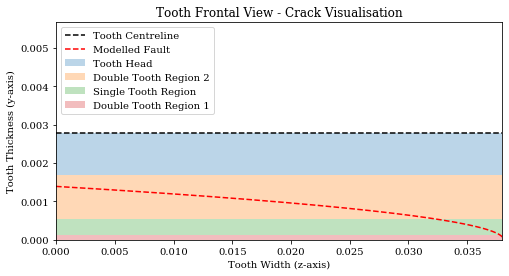

In [245]:
#### Crack
# Fault Parameters
maxfault = Rb1*(np.sin(A2(Z1,a0)))
print('Maximum depth a fault can go before reaching half way = {} mm '.format(np.round(maxfault,4)))
# hmin = 0.0006884439066904911
hmax = maxfault#0.001739407620939356
q0 = 0.5*hmax #+ hmin*1.1#-hmin#1.1*maxfault#0.0025
q2 = 0.05*q0#0.999*q0#0.0024999
v = np.deg2rad(90)
Wc = 0.0*L1

print('Our fault goes down {} mm'.format(np.round(q0*np.sin(v),4)))
alpha_mem, Lx_mem, Ax_mem, Ix_mem = generateCrackingFaults(q0,q2,v,Wc,Z1,Z2, L1,Rb1,Rr1,1000,a0)



crackAngle = np.deg2rad(90)
pWc = Wc#L1*0.8
pq0 = q0
pq2 = q2


pz = np.linspace(0,L1,1000)
pq = np.zeros(len(pz))
for i in range(len(pz)):
    if pq2 == 0:
        if pz[i] <= pWc:
            q = pq0*np.sqrt((pWc-pz[i])/pWc)
        else:
            q = 0
    else:
        q = np.sqrt((pq2**2-pq0**2)/(L1) * pz[i] + pq0**2)
    pq[i] = q * np.sin(crackAngle)
####################





term1 = np.tan(np.arccos((Z1*np.cos(a0))/(Z1+2)))
term2 = -2*np.pi/Z1
term3 = -np.tan(np.arccos(Z1*np.cos(a0)/np.sqrt((Z2+2)**2 +(Z1+Z2)**2-2*(Z2+2)*(Z1+Z2)*np.cos(np.arccos(Z2*np.cos(a0)/(Z2+2))-a0))))

Td = (term1 + term2 + term3) # Double Meshing Angle
Ts = 2*np.pi/Z1 - Td # Single Meshing Angle

Theta_tot = Td+Ts+Td

fa1 = A1(Theta_tot,Z1,Z2,a0,1,0) # I fix the gear tooth to the driving gear from pair 1
fa2 = A2(Z1,a0)
fa3 = A3(fa2,Rb1,Rr1)


dmax  = Rb1*((fa1+fa2)*np.sin(fa1)+np.cos(fa1)) - Rr1*np.cos(fa3)
hmax = Rb1*np.sin(fa2)
print(hmax)



tarr = np.linspace(-fa1,fa2,1000)


dema1 = A1(tarr,Z1,Z2, a0,1,0) # I fix the gear tooth to the driving gear from pair 1
dema2 = A2(Z1,a0)
dema3 = A3(dema2,Rb1,Rr1)

demalpha_mem = tarr

xarr = Rb1*(-(-demalpha_mem+dema2)*np.sin(demalpha_mem)+np.cos(demalpha_mem)) - Rr1*np.cos(dema3)


plotT = np.array([0,Td,Td+Ts,Td+Ts+Td])
plota1 = -A1(plotT,Z1,Z2,a0,1,0) # I fix the gear tooth to the driving gear from pair 1
plota2 = A2(Z1,a0)
plota3 = A3(plota2,Rb1,Rr1)

hi =  hmax - Rb1*(np.sin(plota2))        #- Rr1*np.cos(plota3)
hd1 = hmax - Rb1*((plota2-plota1[1])*np.cos(plota1[1])+np.sin(plota1[1])) #- Rr1*np.cos(plota3)
hs1 = hmax - Rb1*((plota2-plota1[2])*np.cos(plota1[2])+np.sin(plota1[2])) #- Rr1*np.cos(plota3)
hd2 = hmax - Rb1*((plota2-plota1[3])*np.cos(plota1[3])+np.sin(plota1[3])) #- Rr1*np.cos(plota3)

print(hi,hd1,hs1,hd2)


plt.figure(figsize = (8,4))

plt.fill_between([0,L1],[hmax,hmax],[hd2,hd2],label = 'Tooth Head',alpha = 0.3)
plt.fill_between([0,L1],[hd2,hd2],[hs1,hs1],label = 'Double Tooth Region 2',alpha = 0.3)
plt.fill_between([0,L1],[hs1,hs1],[hd1,hd1],label = 'Single Tooth Region',alpha = 0.3)
plt.fill_between([0,L1],[hd1,hd1],[hi,hi],label = 'Double Tooth Region 1',alpha = 0.3)

plt.plot([0,L1],[hmax, hmax],'k--', label = 'Tooth Centreline')
# plt.plot([0,L1],[hmax+0.0005,hmax+0.0005],'k')

plt.plot(pz,pq, 'r--', label =  'Modelled Fault')
# plt.grid()




plt.ylim([0,2*hmax+0.0001])
plt.xlim([0,L1])
plt.ylabel('Tooth Thickness (y-axis)')
plt.xlabel('Tooth Width (z-axis)')
plt.title('Tooth Frontal View - Crack Visualisation')
plt.legend(loc = 'upper left')
# plt.grid()

# plt.savefig(pathstring+"CrackVisualisation.pdf",bbox_inches = 'tight')

print(q0)
print(q2)
print(v)
print(Wc)
print(2*hmax)


In [246]:
angs2, stiffsh2 = stiffnessCompiler(Z1,Z2,L1,L2,Rb1,Rb2,Rr1,Rr2,Ra,np.deg2rad(20))
angs2, stiffs_crack2 = stiffnessCompiler(Z1,Z2,L1,L2,Rb1,Rb2,Rr1,Rr2,Ra,np.deg2rad(20),5,100,1,np.array([q0,q2,v,Wc]))
angs2, stiffs_broke2 = stiffnessCompiler(Z1,Z2,L1,L2,Rb1,Rb2,Rr1,Rr2,Ra,np.deg2rad(20),5,100,4,np.array([0]))

Inducing Cracking Fault on Gear Tooth
Inducing Broken Tooth Fault on Gear Tooth


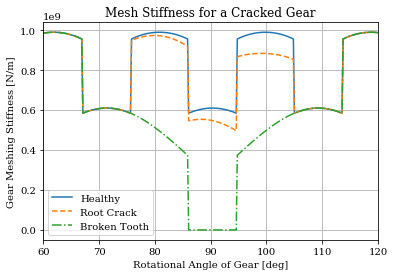

In [247]:
plt.plot(np.rad2deg(angs2),stiffsh2, label = 'Healthy')
plt.plot(np.rad2deg(angs2),stiffs_crack2,'--', label = 'Root Crack')
plt.plot(np.rad2deg(angs2),stiffs_broke2,'-.', label = 'Broken Tooth')
plt.xlim(60,120)
plt.legend()
plt.title('Mesh Stiffness for a Cracked Gear')
plt.xlabel('Rotational Angle of Gear [deg]')
plt.ylabel('Gear Meshing Stiffness [N/m]')
plt.title('Mesh Stiffness for a Cracked Gear')
plt.grid()
# plt.savefig(pathstring+"CrackStiffness.pdf",bbox_inches = 'tight')

# Chips

0.5216459718440399
0.011138747185804071
0.003358873531993583
0.0304
0.0035


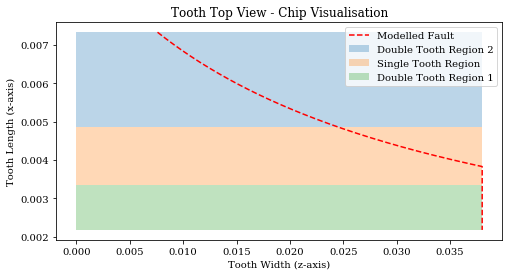

In [248]:
# Fault Parameters
chip_breadth = L1*0.8#08 #Half of the tooth width eventually
chip_depth = 0.0035 # Not too deep
alpha_mem, dL_mem, dAx_mem, dIx_mem = generateChippingFaults(chip_depth,chip_breadth,Z1,Z2,L1, Rb1, Rr1, 1000, a0)




term1 = np.tan(np.arccos((Z1*np.cos(a0))/(Z1+2)))
term2 = -2*np.pi/Z1
term3 = -np.tan(np.arccos(Z1*np.cos(a0)/np.sqrt((Z2+2)**2 +(Z1+Z2)**2-2*(Z2+2)*(Z1+Z2)*np.cos(np.arccos(Z2*np.cos(a0)/(Z2+2))-a0))))
Td = (term1 + term2 + term3) # Double Meshing Angle
Ts = 2*np.pi/Z1 - Td # Single Meshing Angle
Theta_tot = Td+Ts+Td
fa1 = A1(Theta_tot,Z1,Z2,a0,1,0) # I fix the gear tooth to the driving gear from pair 1
fa2 = A2(Z1,a0)
fa3 = A3(fa2,Rb1,Rr1)
print(np.min(fa1))


dmax  = Rb1*((fa1+fa2)*np.sin(fa1)+np.cos(fa1)) - Rr1*np.cos(fa3)
tarr = np.linspace(-fa1,fa2,1000)
dema1 = A1(tarr,Z1,Z2,a0,1,0) # I fix the gear tooth to the driving gear from pair 1 #
dema2 = A2(Z1,a0)#
dema3 = A3(dema2,Rb1,Rr1)#
demalpha_mem = tarr#
xarr = Rb1*(-(-demalpha_mem+dema2)*np.sin(demalpha_mem)+np.cos(demalpha_mem)) - Rr1*np.cos(dema3)#




plotT = np.array([0,Td,Td+Ts,Td+Ts+Td])
plota1 = A1(plotT,Z1,Z2,a0,1,0) # I fix the gear tooth to the driving gear from pair 1
plota2 = A2(Z1,a0)
plota3 = A3(plota2,Rb1,Rr1)
print(np.min(plota1))
xi =  Rb1*(-(-plota2+plota2)*np.sin(plota2)    +np.cos(plota2))    - Rr1*np.cos(plota3)
xd1 = Rb1*((plota1[1]+plota2)*np.sin(plota1[1])+np.cos(plota1[1])) - Rr1*np.cos(plota3)
xs1 = Rb1*((plota1[2]+plota2)*np.sin(plota1[2])+np.cos(plota1[2])) - Rr1*np.cos(plota3)
xd2 = Rb1*((plota1[3]+plota2)*np.sin(plota1[3])+np.cos(plota1[3])) - Rr1*np.cos(plota3)




# xarrr = Rb1*(-(-demalpha_mem+dema2)*np.sin(demalpha_mem)+np.cos(demalpha_mem)) - Rr1*np.cos(dema3)


plt.figure(figsize = (8,4))
# plt.plot([0,L1],[hmax, hmax],'k--', label = 'Tooth Centreline')
plt.plot(dL_mem,xarr,'r--', label = 'Modelled Fault')
# plt.fill_between([0,L1],[hmax,hmax],[hd2,hd2],label = 'Tooth Head',alpha = 0.3)
# plt.fill_between([0,L1],[hd2,hd2],[hs1,hs1],label = 'Double Tooth Region 2',alpha = 0.3)
# plt.fill_between([0,L1],[hs1,hs1],[hd1,hd1],label = 'Single Tooth Region',alpha = 0.3)
# plt.fill_between([0,L1],[hd1,hd1],[hi,hi],label = 'Double Tooth Region 1',alpha = 0.3)
plt.fill_between([0,L1],[xd2,xd2],[xs1,xs1],label = 'Double Tooth Region 2',alpha = 0.3)
plt.fill_between([0,L1],[xs1,xs1],[xd1,xd1],label = 'Single Tooth Region',alpha = 0.3)
plt.fill_between([0,L1],[xd1,xd1],[xi,xi],label = 'Double Tooth Region 1',alpha = 0.3)


# plt.ylim(0,0.004)
# plt.xlim(0,0.02)
plt.title('Tooth Top View - Chip Visualisation')
plt.xlabel('Tooth Width (z-axis)')
plt.ylabel('Tooth Length (x-axis)')
plt.legend()
# print(xd1)
print(Rb1*((plota1[1]+plota2)*np.sin(plota1[1])+np.cos(plota1[1])) - Rr1*np.cos(plota3))
# plt.title('Tooth Side View - Chip Visualisation')
# plt.savefig(pathstring+"ChipVisualisation.pdf",bbox_inches = 'tight')
# alpha_memh, L_memh, Ax_memh, Ix_memh = generateFaults(testx1,0,testl1,testh1,Z1,L1,Rb1,Rr1,1000) # Healthy

print(chip_breadth) # c
print(chip_depth) # b
# chip_breadth = L1*0.8#08 #Half of the tooth width eventually
# chip_depth = 0.0035 # Not too deep


In [221]:
angs2, stiffs_chip2 = stiffnessCompiler(Z1,Z2,L1,L2,Rb1,Rb2,Rr1,Rr2,Ra,np.deg2rad(20),5,100,2,np.array([chip_depth,chip_breadth]))


Inducing Chipping Fault on Gear Tooth


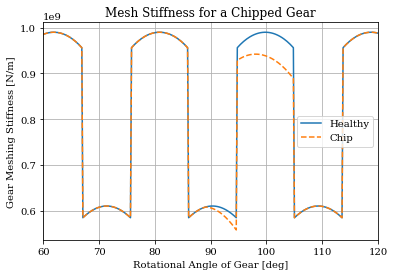

In [222]:
plt.plot(np.rad2deg(angs2),stiffsh2, label = 'Healthy')
plt.plot(np.rad2deg(angs2),stiffs_chip2,'--', label = 'Chip')
plt.xlim(60,120)
plt.legend()
plt.xlabel('Rotational Angle of Gear [deg]')
plt.ylabel('Gear Meshing Stiffness [N/m]')
plt.title('Mesh Stiffness for a Chipped Gear')
plt.grid()
plt.savefig(pathstring+"ChipStiffness.pdf",bbox_inches = 'tight')

# Spall

0.006
0.0019
0.0304
0.002


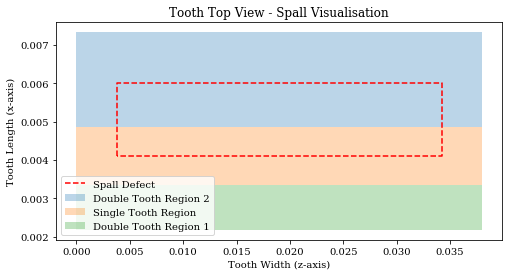

In [250]:
term1 = np.tan(np.arccos((Z1*np.cos(a0))/(Z1+2)))
term2 = -2*np.pi/Z1
term3 = -np.tan(np.arccos(Z1*np.cos(a0)/np.sqrt((Z2+2)**2 +(Z1+Z2)**2-2*(Z2+2)*(Z1+Z2)*np.cos(np.arccos(Z2*np.cos(a0)/(Z2+2))-a0))))

Td = (term1 + term2 + term3) # Double Meshing Angle
Ts = 2*np.pi/Z1 - Td # Single Meshing Angle

Theta_tot = Td+Ts+Td


fa1 = A1(Theta_tot,Z1, Z2, a0, 1,0) # I fix the gear tooth to the driving gear from pair 1
fa2 = A2(Z1,a0)
fa3 = A3(fa2,Rb1,Rr1)


dmax  = Rb1*((fa1+fa2)*np.sin(fa1)+np.cos(fa1)) - Rr1*np.cos(fa3)



tarr = np.linspace(-fa1,fa2,1000)

testx1 = 0.006
testw1 = 0.05*L1
testl1 = 0.8*L1
testh1 = 0.002


# ##############################################################################


dema1 = A1(tarr,Z1,Z2, a0, 1,0) # I fix the gear tooth to the driving gear from pair 1
dema2 = A2(Z1, a0)
dema3 = A3(dema2,Rb1,Rr1)

demalpha_mem = tarr

xarr = Rb1*(-(-demalpha_mem+dema2)*np.sin(demalpha_mem)+np.cos(demalpha_mem)) - Rr1*np.cos(dema3)


plotT = np.array([0,Td,Td+Ts,Td+Ts+Td])
plota1 = A1(plotT,Z1, Z2, a0,1,0) # I fix the gear tooth to the driving gear from pair 1
plota2 = A2(Z1,a0)
plota3 = A3(plota2,Rb1,Rr1)

xi =  Rb1*(-(-plota2+plota2)*np.sin(plota2)+np.cos(plota2))        - Rr1*np.cos(plota3)
xd1 = Rb1*((plota1[1]+plota2)*np.sin(plota1[1])+np.cos(plota1[1])) - Rr1*np.cos(plota3)
xs1 = Rb1*((plota1[2]+plota2)*np.sin(plota1[2])+np.cos(plota1[2])) - Rr1*np.cos(plota3)
xd2 = Rb1*((plota1[3]+plota2)*np.sin(plota1[3])+np.cos(plota1[3])) - Rr1*np.cos(plota3)




plt.figure(figsize = (8,4))
# plt.subplot(1,2,1)

plt.fill_between([0,L1],[xd2,xd2],[xs1,xs1],label = 'Double Tooth Region 2',alpha = 0.3)
plt.fill_between([0,L1],[xs1,xs1],[xd1,xd1],label = 'Single Tooth Region',alpha = 0.3)
plt.fill_between([0,L1],[xd1,xd1],[xi,xi],label = 'Double Tooth Region 1',alpha = 0.3)

# plt.scatter(testWidth, testU, s=100*testR/np.max(testR),c=50*testR/np.max(testR), alpha=0.9)
# plt.grid()

# plt.ylim([0,dmax])
# plt.xlim([0,L1])
plt.title('Tooth Top View - Spall Visualisation')
plt.xlabel('Tooth Width (z-axis)')
plt.ylabel('Tooth Length (x-axis)')
plt.plot([(L1-testl1)/2,(L1-testl1)/2,(L1-testl1)/2+testl1,(L1-testl1)/2+testl1,(L1-testl1)/2],[testx1-testw1,testx1,testx1,testx1-testw1,testx1-testw1],'r--', label = 'Spall Defect')
plt.legend(loc = 'lower left')
# plt.savefig(pathstring+"SpallVisualisation.pdf",bbox_inches = 'tight')
print(testx1)
print(testw1)
print(testl1)
print(testh1)


# testx1 = 0.006
# testw1 = 0.05*L1
# testl1 = 0.8*L1
# testh1 = 0.002



In [224]:
angs2, stiffs_spall2 = stiffnessCompiler(Z1,Z2,L1,L2,Rb1,Rb2,Rr1,Rr2,Ra,np.deg2rad(20),5,100,5,np.array([testx1,testl1,testw1,testh1]))

Inducing Spall Fault on Gear Tooth


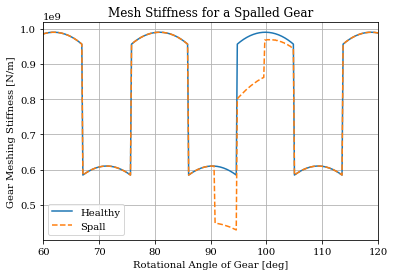

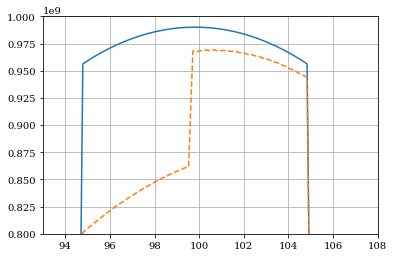

In [234]:
plt.figure()
plt.plot(np.rad2deg(angs2),stiffsh2, label = 'Healthy')
plt.plot(np.rad2deg(angs2),stiffs_spall2,'--', label = 'Spall')
plt.xlim(60,120)
plt.legend()
plt.title('Mesh Stiffness for a Spalled Gear')
plt.xlabel('Rotational Angle of Gear [deg]')
plt.ylabel('Gear Meshing Stiffness [N/m]')
plt.grid()
plt.savefig(pathstring+"SpallStiffness.pdf",bbox_inches = 'tight')


plt.figure()
plt.plot(np.rad2deg(angs2),stiffsh2, label = 'Healthy')
plt.plot(np.rad2deg(angs2),stiffs_spall2,'--', label = 'Spall')
plt.xlim(93,108)
# plt.legend()
plt.grid()
plt.ylim(0.8e9,1e9)
# plt.axis('off')
plt.savefig(pathstring+"SpallStiffness2.pdf",bbox_inches = 'tight')

# Pitting

In [269]:
# Fault Parameters
a2 = A2(Z1,a0)
a3 = A3(a2,Rb1,Rr1)
noFaults = 50
d1 = np.sqrt(Rb1**2 + Rr1**2 - 2*Rb1*Rr1*np.cos(a3-a2)) # This is 0.48% different from just simply saying Rb-Rr    
testU= np.random.normal(1*d1*2,0.0005,noFaults)
# testR = np.random.uniform(0.0002,0.0006,noFaults)
testR = np.random.uniform(0.0002,0.001,noFaults)
testPA = np.random.uniform(np.pi/6,np.pi/3,noFaults)
testWidth = np.random.uniform(L1*0.01,L1*0.99,noFaults) # Plotting Purposes Only

alpha_mem, dL_mem, dAx_mem, dIx_mem = generatePittingFaults(testU,testPA,testR,Z1,Z2,L1,Rb1,Rr1,1000,a0)

In [274]:
print(1*d1*2)


0.004355736599990833


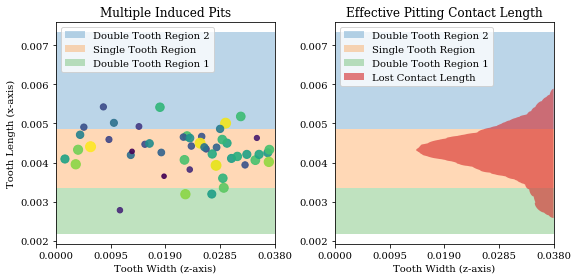

In [275]:
term1 = np.tan(np.arccos((Z1*np.cos(a0))/(Z1+2)))
term2 = -2*np.pi/Z1
term3 = -np.tan(np.arccos(Z1*np.cos(a0)/np.sqrt((Z2+2)**2 +(Z1+Z2)**2-2*(Z2+2)*(Z1+Z2)*np.cos(np.arccos(Z2*np.cos(a0)/(Z2+2))-a0))))

Td = (term1 + term2 + term3) # Double Meshing Angle
Ts = 2*np.pi/Z1 - Td # Single Meshing Angle

Theta_tot = Td+Ts+Td

fa1 = A1(Theta_tot,Z1,Z2,a0,1,0) # I fix the gear tooth to the driving gear from pair 1
fa2 = A2(Z1,a0)
fa3 = A3(fa2,Rb1,Rr1)


dmax  = Rb1*((fa1+fa2)*np.sin(fa1)+np.cos(fa1)) - Rr1*np.cos(fa3)



tarr = np.linspace(-fa1,fa2,1000)

dL = getdLVal(tarr,alpha_mem,dL_mem)
dAx = getdAxVal(tarr,alpha_mem,dAx_mem)
dIx = getdIxVal(tarr,alpha_mem,dIx_mem)


dema1 = A1(tarr,Z1,Z2,a0,1,0) # I fix the gear tooth to the driving gear from pair 1
dema2 = A2(Z1,a0)
dema3 = A3(dema2,Rb1,Rr1)

demalpha_mem = tarr

xarr = Rb1*(-(-demalpha_mem+dema2)*np.sin(demalpha_mem)+np.cos(demalpha_mem)) - Rr1*np.cos(dema3)


plotT = np.array([0,Td,Td+Ts,Td+Ts+Td])
plota1 = A1(plotT,Z1,Z2,a0,1,0) # I fix the gear tooth to the driving gear from pair 1
plota2 = A2(Z1,a0)
plota3 = A3(plota2,Rb1,Rr1)

xi =  Rb1*(-(-plota2+plota2)*np.sin(plota2)+np.cos(plota2))        - Rr1*np.cos(plota3)
xd1 = Rb1*((plota1[1]+plota2)*np.sin(plota1[1])+np.cos(plota1[1])) - Rr1*np.cos(plota3)
xs1 = Rb1*((plota1[2]+plota2)*np.sin(plota1[2])+np.cos(plota1[2])) - Rr1*np.cos(plota3)
xd2 = Rb1*((plota1[3]+plota2)*np.sin(plota1[3])+np.cos(plota1[3])) - Rr1*np.cos(plota3)




plt.figure(figsize = (8,4))
plt.subplot(1,2,1)

plt.fill_between([0,L1],[xd2,xd2],[xs1,xs1],label = 'Double Tooth Region 2',alpha = 0.3)
plt.fill_between([0,L1],[xs1,xs1],[xd1,xd1],label = 'Single Tooth Region',alpha = 0.3)
plt.fill_between([0,L1],[xd1,xd1],[xi,xi],label = 'Double Tooth Region 1',alpha = 0.3)

plt.scatter(testWidth, testU, s=100*testR/np.max(testR),c=50*testR/np.max(testR), alpha=0.9)
# plt.grid()

# plt.ylim([0,dmax])
plt.xlim([0,L1])
plt.title('Multiple Induced Pits', wrap = True)
plt.xlabel('Tooth Width (z-axis)')
plt.ylabel('Tooth Length (x-axis)')
plt.xticks(np.linspace(0,L1,5))

plt.legend(loc = 'upper left')


plt.subplot(1,2,2)
plt.tight_layout(w_pad = 2)

plt.fill_between([0,L1],[xd2,xd2],[xs1,xs1],label = 'Double Tooth Region 2',alpha = 0.3)
plt.fill_between([0,L1],[xs1,xs1],[xd1,xd1],label = 'Single Tooth Region',alpha = 0.3)
plt.fill_between([0,L1],[xd1,xd1],[xi,xi],label = 'Double Tooth Region 1',alpha = 0.3)



# plt.plot(L1-dL,xarr)
plt.fill_betweenx(xarr,L1,dL,alpha = 0.6,label = 'Lost Contact Length')
plt.xlim([0,L1])
# plt.ylim([0,dmax])
plt.title('Effective Pitting Contact Length', wrap = True)
plt.xlabel('Tooth Width (z-axis)')
plt.xticks(np.linspace(0,L1,5))

# plt.grid()

plt.legend(loc = 'upper left')
plt.savefig(pathstring+"PitVisualisation.pdf",bbox_inches = 'tight')

In [272]:
angs2, stiffs_pit2 = stiffnessCompiler(Z1,Z2,L1,L2,Rb1,Rb2,Rr1,Rr2,Ra,np.deg2rad(20),5,100,3,np.array([testU,testPA,testR]))

Inducing Pitting Fault on Gear Tooth


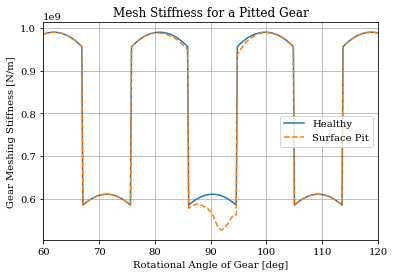

In [276]:
plt.plot(np.rad2deg(angs2),stiffsh2, label = 'Healthy')
plt.plot(np.rad2deg(angs2),stiffs_pit2,'--', label = 'Surface Pit')
plt.xlim(60,120)
plt.legend()
plt.title('Mesh Stiffness for a Pitted Gear')
plt.xlabel('Rotational Angle of Gear [deg]')
plt.ylabel('Gear Meshing Stiffness [N/m]')
plt.grid()
# plt.savefig(pathstring+"PitStiffness.pdf",bbox_inches = 'tight')

# All Faults

In [277]:
angs2, stiffsh2 = stiffnessCompiler(Z1,Z2,L1,L2,Rb1,Rb2,Rr1,Rr2,Ra,np.deg2rad(20))
angs2, stiffs_crack2 = stiffnessCompiler(Z1,Z2,L1,L2,Rb1,Rb2,Rr1,Rr2,Ra,np.deg2rad(20),1,100,1,np.array([q0,q2,v,Wc]))
angs2, stiffs_chip2 = stiffnessCompiler(Z1,Z2,L1,L2,Rb1,Rb2,Rr1,Rr2,Ra,np.deg2rad(20),3,100,2,np.array([chip_depth,chip_breadth]))
angs2, stiffs_spall2 = stiffnessCompiler(Z1,Z2,L1,L2,Rb1,Rb2,Rr1,Rr2,Ra,np.deg2rad(20),5,100,5,np.array([testx1,testl1,testw1,testh1]))
angs2, stiffs_pit2 = stiffnessCompiler(Z1,Z2,L1,L2,Rb1,Rb2,Rr1,Rr2,Ra,np.deg2rad(20),7,100,3,np.array([testU,testPA,testR]))
angs2, stiffs_broke2 = stiffnessCompiler(Z1,Z2,L1,L2,Rb1,Rb2,Rr1,Rr2,Ra,np.deg2rad(20),9,100,4,np.array([0]))



Inducing Cracking Fault on Gear Tooth
Inducing Chipping Fault on Gear Tooth
Inducing Spall Fault on Gear Tooth
Inducing Pitting Fault on Gear Tooth
Inducing Broken Tooth Fault on Gear Tooth


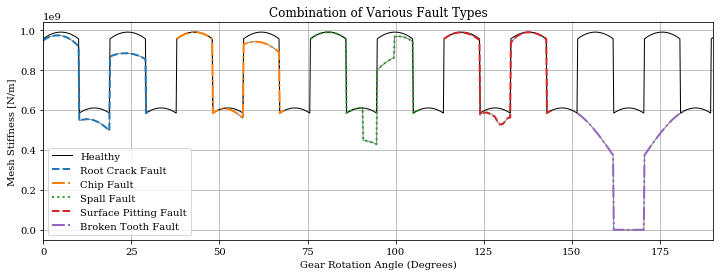

In [279]:

plt.figure(figsize = (12,4))
plt.plot(np.rad2deg(angs2),stiffsh2, 'k', label = 'Healthy', lw = 1)
plt.plot(np.rad2deg(angs2)[0:162],stiffs_crack2[0:162], 'k', lw = 1, alpha = 0.5)
plt.plot(np.rad2deg(angs2)[0:162],stiffs_crack2[0:162], '--', label = 'Root Crack Fault', lw = 2)
plt.plot(np.rad2deg(angs2)[200:362],stiffs_chip2[200:362], 'k', lw = 1, alpha = 0.5)
plt.plot(np.rad2deg(angs2)[200:362],stiffs_chip2[200:362], '-.', label = 'Chip Fault', lw = 2)
plt.plot(np.rad2deg(angs2)[400:562],stiffs_spall2[400:562],'k', lw = 1, alpha = 0.5)
plt.plot(np.rad2deg(angs2)[400:562],stiffs_spall2[400:562], ':',  label = 'Spall Fault', lw = 2)
plt.plot(np.rad2deg(angs2)[600:762],stiffs_pit2[600:762],'k', lw = 1, alpha = 0.5)
plt.plot(np.rad2deg(angs2)[600:762],stiffs_pit2[600:762],'--', label = 'Surface Pitting Fault', lw = 2)
plt.plot(np.rad2deg(angs2)[800:962],stiffs_broke2[800:962],'k', lw = 1, alpha = 0.5)
plt.plot(np.rad2deg(angs2)[800:962],stiffs_broke2[800:962],'-.', label = 'Broken Tooth Fault', lw = 2)


plt.xlabel('Gear Rotation Angle (Degrees)')
plt.ylabel('Mesh Stiffness [N/m]')
plt.grid()
plt.xlim(0,190)
plt.legend()
plt.title('Combination of Various Fault Types')

# plt.savefig(pathstring+"GeneralisedCompilation.pdf",bbox_inches = 'tight')


# Construction of meshing stiffness

In [218]:
angs, stiffsh = stiffnessCompiler2(Z1,Z2,L1,L2,Rb1,Rb2,Rr1,Rr2,Ra,np.deg2rad(20))
stiffstot = stiffsh2

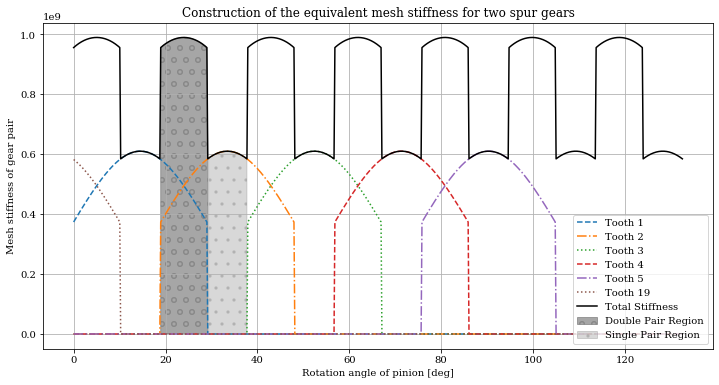

In [219]:
plt.figure(figsize = (12,6))
plt.plot(np.rad2deg(angs[0:700]),stiffsh[0][0:700],'--',label = 'Tooth 1')
plt.plot(np.rad2deg(angs[0:700]),stiffsh[1][0:700],'-.',label = 'Tooth 2')
plt.plot(np.rad2deg(angs[0:700]),stiffsh[2][0:700],':',label = 'Tooth 3')
plt.plot(np.rad2deg(angs[0:700]),stiffsh[3][0:700],'--',label = 'Tooth 4')
plt.plot(np.rad2deg(angs[0:700]),stiffsh[4][0:700],'-.',label = 'Tooth 5')
plt.plot(np.rad2deg(angs[0:700]),stiffsh[18][0:700],':',label = 'Tooth 19')
plt.plot(np.rad2deg(angs[0:700]),stiffstot[0:700],'k',label = 'Total Stiffness')
plt.fill_between(np.rad2deg(angs[100:155]),stiffstot[100:155],0,label = 'Double Pair Region',alpha = 0.7, hatch = "o", color = "gray")
plt.fill_between(np.rad2deg(angs[155:200]),stiffstot[155:200],0,label = 'Single Pair Region',alpha = 0.3, hatch = ".", color = "gray")
plt.legend(ncol=1,loc='lower right')
plt.xlabel('Rotation angle of pinion [deg]')
plt.ylabel('Mesh stiffness of gear pair')
plt.title('Construction of the equivalent mesh stiffness for two spur gears')


# Making fonts look good!
import matplotlib
matplotlib.rcParams.update({
    'font.family': 'serif',
    'text.usetex': False,
})
plt.grid()

# pathstring = "/Users/lukevaneyk/OneDrive - University of Pretoria/Postgrad/Masters/Figures/"
plt.savefig(pathstring+"StiffnessComp.pdf",bbox_inches = 'tight')